# Purpose
The purpose of this notebook is to learn how to consolidate categorical features from `data/immo_data202208_v2.parquet` in one column each.

# Summary

| Feature       | Complete Data found in/with | 
| ------------- | --------------------------- |
| Municipality  | RegEx `\d{4} (.+?),` on `address` and `\d{4} (.+)$` on `address_s`, then merge |
| Zip Code      | RegEx `(\d{4}) [A-ZÀ-Ÿ]` on `address` and `address_s`, then merge                | 
| Canton        | Read from xlsx                                                                   | 
| Street        | RegEx `(.+), \d{4}` from `address` and `address_s`, then merge                   |
| Street Number | RegEx `^.+ (\d.+)` from above merged `street`                                    |
| Availability  | Merge `Availability_merged` and `detail_responsive#available_from`               |

In [1]:
# Import modules
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")


In [2]:
df = pd.read_parquet(
    "https://github.com/Immobilienrechner-Challenge/data/blob/main/immo_data_202208_v2.parquet?raw=true"
)


# Address
We discovered that the following columns contain information about the address of an object:
- `Municipality` (+9126) 
- `address` (=)
- `address_s` (new)
- `location` (+9126)
- `location_parsed` (+9126)
- `Zip` (+9126)
- `plz` (new)
- `plz_parsed` (new)

## Municipality and postal code
Again we first focus on the municipality and the postal code.

In [3]:
# Select relevant postal code columns
cols_plz = ["Zip", "plz", "plz_parsed"]
df_plz = df[cols_plz].copy()

df_plz["from_address"] = df["address"].str.extract(r"(\d{4}) [A-ZÀ-Ÿ]")
df_plz["from_address_s"] = df["address_s"].str.extract("(\d{4}) [A-ZÀ-Ÿ]")
df_plz["from_location"] = df["location"].str.extract("(\d{4}) [A-ZÀ-Ÿ]")
df_plz["from_location_parsed"] = df["location_parsed"].str.extract("plz: ?(\d+)")


### NA Heatmap

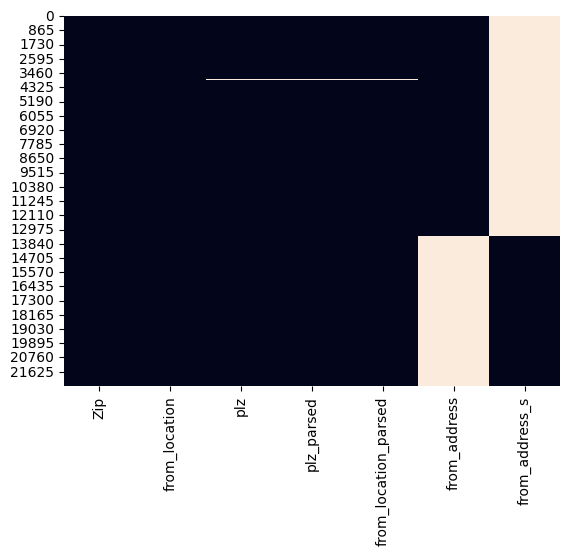

In [4]:
# Sort columns by number of non-null values
df_plz = df_plz.reindex(df_plz.count().sort_values(ascending=False).index, axis=1)

# Create isna heatmap
sns.heatmap(df_plz.isna(), cbar=False)
plt.show()


This output shows that many columns appear to contain a complete or almost complete dataset. In [v1](../../v1/exports/4-daw_qualitative.html) of this analysis we concluded that the best source for the address data is the `address` column. With that in mind we merge the two columns `from_address` and `from_address_s` and compare the data to the rest of the columns.

In [5]:
# Merge columns from_address and from_address_s
df_plz["plz_merged"] = df_plz["from_address"].fillna(df_plz["from_address_s"])
df_plz.drop(columns=["from_address", "from_address_s"], inplace=True)


In [6]:
# Show rows with missing values
df_plz[df_plz.isna().any(axis=1)]


,Zip,from_location,plz,plz_parsed,from_location_parsed,plz_merged
3851,8405,4160,NaN,NaN,NaN,4160
4073,8405,7514,NaN,NaN,NaN,7514
4074,8405,7514,NaN,NaN,NaN,7514
4075,8405,7514,NaN,NaN,NaN,7514
4203,8405,7032,NaN,NaN,NaN,7032
4206,8405,7032,NaN,NaN,NaN,7032
4209,8405,7032,NaN,NaN,NaN,7032
4212,8405,7032,NaN,NaN,NaN,7032
10211,8405,1000,NaN,NaN,NaN,1000
10214,8405,1000,NaN,NaN,NaN,1000


This output again highlights that `plz`, `plz_parsed` and `from_location_parsed` have missing values where other columns do not. Also `Zip` seems to still contain wrong data. To inspect this further we add the municipality columns to give more context.

In [7]:
# Add municipality columns
df_plz["municipality"] = df["Municipality"].copy()
df_plz["location_parsed"] = df["location_parsed"].copy()
df_plz["address"] = df["address"].copy()
df_plz["location"] = df["location"].copy()


In [8]:
# Show rows where plz is not equal to plz_parsed
df_plz[df_plz["plz"].fillna(0) != df_plz["plz_parsed"].fillna(0)]


,Zip,from_location,plz,plz_parsed,from_location_parsed,plz_merged,municipality,location_parsed,address,location
12637,3971,3971,397.0,3971.0,3971,3971,Crans-Montana,Strasse: Rue des écoles 3 plz: 3971 Stadt:Cher...,"Rue des écoles 3, 3971 Chermignon-d'en-Bas Cra...","Rue des écoles 3, 3971 Chermignon-d en-Bas Cra..."
14073,1201,1201,1200.0,1201.0,1201,1201,Genève,"Strasse: Rue de la Cloche 6 , plz:1201 Stadt:...",None,"Rue de la Cloche 6, 1201 Genève"
14074,1201,1201,1200.0,1201.0,1201,1201,Genève,"Strasse: Rue de la Cloche 6 , plz:1201 Stadt:...",None,"Rue de la Cloche 6, 1201 Genève"
14075,1204,1206,1200.0,1206.0,1206,1206,Genève,Strasse: plz:1206 Stadt: Genève,None,1206 Genève
14076,1204,1206,1200.0,1206.0,1206,1206,Genève,Strasse: plz:1206 Stadt: Genève,None,1206 Genève
...,...,...,...,...,...,...,...,...,...,...
22318,8044,8044,8000.0,8044.0,8044,8044,Gockhausen,"Strasse: In Grosswiesen 3 , plz:8044 Stadt: ...",None,"In Grosswiesen 3, 8044 Gockhausen"
22319,8049,8049,8000.0,8049.0,8049,8049,Zürich,"Strasse: Ferdinand-Hodler-Strasse 44 , plz:80...",None,"Ferdinand-Hodler-Strasse 44, 8049 Zürich"
22320,8052,8052,8000.0,8052.0,8052,8052,Zürich,"Strasse: Katzenbachstrasse 219 , plz:8052 Sta...",None,"Katzenbachstrasse 219, 8052 Zürich"
22321,8052,8052,8000.0,8052.0,8052,8052,Zürich,"Strasse: Hegnauweg 15 , plz:8052 Stadt: Zürich",None,"Hegnauweg 15, 8052 Zürich"


In the top row we can see that the column `plz` sometimes cuts off the values therefore we discard it.

In [9]:
df_plz.drop(columns=["plz"], inplace=True)


In [10]:
# Show rows where from_location is not equal to from_location_parsed
df_plz[
    df_plz["from_location"].fillna(0).astype(int)
    != df_plz["from_location_parsed"].fillna(0).astype(int)
]


,Zip,from_location,plz_parsed,from_location_parsed,plz_merged,municipality,location_parsed,address,location
3851,8405,4160,NaN,NaN,4160,Troinex,None,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...
4073,8405,7514,NaN,NaN,7514,Sils im Engadin/Segl,None,"7514 Sils/Segl Maria, GR","7514 Sils/Segl Maria, GR"
4074,8405,7514,NaN,NaN,7514,Sils im Engadin/Segl,None,"7514 Sils/Segl Maria, GR","7514 Sils/Segl Maria, GR"
4075,8405,7514,NaN,NaN,7514,Sils im Engadin/Segl,None,"7514 Sils/Segl Maria, GR","7514 Sils/Segl Maria, GR"
4203,8405,7032,NaN,NaN,7032,Laax,None,"Via Brutg 23, 7032 Laax GR 2, GR","Via Brutg 237032 Laax GR 2, GR"
4206,8405,7032,NaN,NaN,7032,Laax,None,"Via Brutg 23, 7032 Laax GR 2, GR","Via Brutg 237032 Laax GR 2, GR"
4209,8405,7032,NaN,NaN,7032,Laax,None,"Via Cuolm Liung 30, 7032 Laax GR 2, GR","Via Cuolm Liung 307032 Laax GR 2, GR"
4212,8405,7032,NaN,NaN,7032,Laax,None,"7032 Laax GR 2, GR","7032 Laax GR 2, GR"
10211,8405,1000,NaN,NaN,1000,Lausanne,None,"1000 Lausanne 26, VD","1000 Lausanne 26, VD"
10214,8405,1000,NaN,NaN,1000,Lausanne,None,"1000 Lausanne 26, VD","1000 Lausanne 26, VD"


As in the previous version we see that `location_parsed` has some issues and by extension `from_location_parsed`, which is why we drop those columns again.

In [11]:
df_plz.drop(columns=["location_parsed", "from_location_parsed"], inplace=True)


In [12]:
# Show rows where from_location is not equal to plz_parsed
df_plz[
    df_plz["from_location"].fillna(0).astype(int)
    != df_plz["plz_parsed"].fillna(0).astype(int)
]


,Zip,from_location,plz_parsed,plz_merged,municipality,address,location
3851,8405,4160,NaN,4160,Troinex,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...
4073,8405,7514,NaN,7514,Sils im Engadin/Segl,"7514 Sils/Segl Maria, GR","7514 Sils/Segl Maria, GR"
4074,8405,7514,NaN,7514,Sils im Engadin/Segl,"7514 Sils/Segl Maria, GR","7514 Sils/Segl Maria, GR"
4075,8405,7514,NaN,7514,Sils im Engadin/Segl,"7514 Sils/Segl Maria, GR","7514 Sils/Segl Maria, GR"
4203,8405,7032,NaN,7032,Laax,"Via Brutg 23, 7032 Laax GR 2, GR","Via Brutg 237032 Laax GR 2, GR"
4206,8405,7032,NaN,7032,Laax,"Via Brutg 23, 7032 Laax GR 2, GR","Via Brutg 237032 Laax GR 2, GR"
4209,8405,7032,NaN,7032,Laax,"Via Cuolm Liung 30, 7032 Laax GR 2, GR","Via Cuolm Liung 307032 Laax GR 2, GR"
4212,8405,7032,NaN,7032,Laax,"7032 Laax GR 2, GR","7032 Laax GR 2, GR"
10211,8405,1000,NaN,1000,Lausanne,"1000 Lausanne 26, VD","1000 Lausanne 26, VD"
10214,8405,1000,NaN,1000,Lausanne,"1000 Lausanne 26, VD","1000 Lausanne 26, VD"


The column `plz_parsed` has missing values where `from_location` and `plz_merged` do not. Also `Zip` seems to fallback to 8405 where `plz_parsed` is missing. 

In [13]:
# Show rows where Zip is not equal to plz_parsed
df_plz[
    df_plz["Zip"].fillna(0).astype(int) != df_plz["plz_parsed"].fillna(0).astype(int)
]


,Zip,from_location,plz_parsed,plz_merged,municipality,address,location
2,5000,5022,5022.0,5022,None,"5022 Rombach, AG","5022 Rombach, AG"
7,5000,5004,5004.0,5004,Aarau,"5004 Aarau, AG","5004 Aarau, AG"
10,5000,5004,5004.0,5004,Aarau,"Rütmattstrasse 17, 5004 Aarau, AG","Rütmattstrasse 175004 Aarau, AG"
23,5417,5301,5301.0,5301,Untersiggenthal,"5301 Siggenthal Station, AG","5301 Siggenthal Station, AG"
27,5412,5300,5300.0,5300,Turgi,"5300 Turgi, AG","5300 Turgi, AG"
...,...,...,...,...,...,...,...
22293,6934,6992,6992.0,6992,Bioggio,None,6992 Bioggio
22294,6934,6992,6992.0,6992,Vernate,None,6992 Vernate
22308,7464,7463,7463.0,7463,Riom,None,"PLAZ FRAVESCH, 7463 Riom"
22372,8404,8400,8400.0,8400,Reutlingen,None,8400 Reutlingen (Winterthur)


In [14]:
# Show rows where Zip is not equal to plz_merged
df_plz[
    df_plz["Zip"].fillna(0).astype(int) != df_plz["plz_merged"].fillna(0).astype(int)
]


,Zip,from_location,plz_parsed,plz_merged,municipality,address,location
2,5000,5022,5022.0,5022,None,"5022 Rombach, AG","5022 Rombach, AG"
7,5000,5004,5004.0,5004,Aarau,"5004 Aarau, AG","5004 Aarau, AG"
10,5000,5004,5004.0,5004,Aarau,"Rütmattstrasse 17, 5004 Aarau, AG","Rütmattstrasse 175004 Aarau, AG"
23,5417,5301,5301.0,5301,Untersiggenthal,"5301 Siggenthal Station, AG","5301 Siggenthal Station, AG"
27,5412,5300,5300.0,5300,Turgi,"5300 Turgi, AG","5300 Turgi, AG"
...,...,...,...,...,...,...,...
22293,6934,6992,6992.0,6992,Bioggio,None,6992 Bioggio
22294,6934,6992,6992.0,6992,Vernate,None,6992 Vernate
22308,7464,7463,7463.0,7463,Riom,None,"PLAZ FRAVESCH, 7463 Riom"
22372,8404,8400,8400.0,8400,Reutlingen,None,8400 Reutlingen (Winterthur)


There are 4191 rows where `Zip` contains different data than `plz_parsed` and `plz_merged`.

In [15]:
# Show rows where plz_merged is not equal to plz_parsed
df_plz[
    df_plz["plz_parsed"].fillna(0).astype(int)
    != df_plz["plz_merged"].fillna(0).astype(int)
]


,Zip,from_location,plz_parsed,plz_merged,municipality,address,location
3851,8405,4160,NaN,4160,Troinex,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...
4073,8405,7514,NaN,7514,Sils im Engadin/Segl,"7514 Sils/Segl Maria, GR","7514 Sils/Segl Maria, GR"
4074,8405,7514,NaN,7514,Sils im Engadin/Segl,"7514 Sils/Segl Maria, GR","7514 Sils/Segl Maria, GR"
4075,8405,7514,NaN,7514,Sils im Engadin/Segl,"7514 Sils/Segl Maria, GR","7514 Sils/Segl Maria, GR"
4203,8405,7032,NaN,7032,Laax,"Via Brutg 23, 7032 Laax GR 2, GR","Via Brutg 237032 Laax GR 2, GR"
4206,8405,7032,NaN,7032,Laax,"Via Brutg 23, 7032 Laax GR 2, GR","Via Brutg 237032 Laax GR 2, GR"
4209,8405,7032,NaN,7032,Laax,"Via Cuolm Liung 30, 7032 Laax GR 2, GR","Via Cuolm Liung 307032 Laax GR 2, GR"
4212,8405,7032,NaN,7032,Laax,"7032 Laax GR 2, GR","7032 Laax GR 2, GR"
10211,8405,1000,NaN,1000,Lausanne,"1000 Lausanne 26, VD","1000 Lausanne 26, VD"
10214,8405,1000,NaN,1000,Lausanne,"1000 Lausanne 26, VD","1000 Lausanne 26, VD"


Also there are rows where `plz_parsed` is not equal to `plz_merged`. Taking all the above findings into consideration we decided that `plz_parsed` and `Zip` are suffering from issues where `plz_merged` does not so we drop them. 

In [16]:
df_plz.drop(columns=["plz_parsed", "Zip"], inplace=True)


In [17]:
df_plz[df_plz["plz_merged"].isna()]


,from_location,plz_merged,municipality,address,location


In [18]:
# Show rows where plz_merged is not equal to from_location
df_plz[
    df_plz["from_location"].fillna(0).astype(int)
    != df_plz["plz_merged"].fillna(0).astype(int)
]


,from_location,plz_merged,municipality,address,location


This comparison shows that `from_location` and `plz_merged` contain the same data so we can use either one. We decided to use `plz_merged`.

In [19]:
df_plz.drop(columns="from_location", inplace=True)


Again we want to verify that the merged data is valid so we prepare the validation dataset.

In [20]:
df_xlsx_plz = pd.read_excel(
    "https://github.com/Immobilienrechner-Challenge/data/raw/main/plz.xlsx",
    sheet_name="Blatt1",
)


In [21]:
df_xlsx_plz.drop(
    ["Kanton", "Canton", "Cantone", "Land", "Pays", "Paese"], axis=1, inplace=True
)
df_xlsx_plz.rename(
    columns={
        df_xlsx_plz.columns[0]: "plz",
        df_xlsx_plz.columns[1]: "municipality",
        df_xlsx_plz.columns[2]: "kanton",
    },
    inplace=True,
)


In [22]:
# Check what postal codes are not in the xlsx file
df_plz["plz_merged"] = df_plz["plz_merged"].astype(int)
df_plz["plz_merged"].isin(df_xlsx_plz["plz"]).value_counts()


True     22473
False        8
Name: plz_merged, dtype: int64

There are 8 postal codes that cannot be verified.

In [23]:
# Select rows where plz_merged is not in the xlsx file
df_plz[~df_plz["plz_merged"].isin(df_xlsx_plz["plz"])]


,plz_merged,municipality,address,location
3851,4160,Troinex,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...
16724,1818,Montreux,None,1818 Montreux
18066,1919,Martigny,None,1919 Martigny
20414,2737,Bévilard,None,2737 Bévilard
20415,2737,Bévilard,None,2737 Bévilard
20782,3217,Mühlethurnen,None,3217 Mühlethurnen
20783,3217,Mühlethurnen,None,3217 Mühlethurnen
20920,3364,Seeberg,None,"Dorfstrasse 22, 3364 Seeberg"


Like in the previous version of the dataset there's an observation from france which we cannot take into consideration so we drop it. 

In [24]:
df_plz.drop(3851, inplace=True)


In [25]:
df_plz[~df_plz["plz_merged"].isin(df_xlsx_plz["plz"])]


,plz_merged,municipality,address,location
16724,1818,Montreux,None,1818 Montreux
18066,1919,Martigny,None,1919 Martigny
20414,2737,Bévilard,None,2737 Bévilard
20415,2737,Bévilard,None,2737 Bévilard
20782,3217,Mühlethurnen,None,3217 Mühlethurnen
20783,3217,Mühlethurnen,None,3217 Mühlethurnen
20920,3364,Seeberg,None,"Dorfstrasse 22, 3364 Seeberg"


We double checked the above data with post.ch and found that 
- the postal code 1818 corresponds to Montreux La Redoute -> no action needed here
- postal code 1919 corresponds to Martigny Groupe Mutuel -> no action needed 
- postal code 2737 is non existent, but the postal code for Bévilard is 2735 (maybe a typo)
- postal code 3217 does not exist but the postal code for Mühlenthurnen is 3127 (again typo)
- postal code 3364 does not exist but the postal code for Seeberg is 3365 (also typo)

Correcting those rows should result in a valid dataset. 

To ensure consistency we also extract the municipality from `address` and `address_s` and verify that this results in a complete dataset.

In [26]:
# set plz_merged to 2735 for rows where plz_merged is 2734
df_plz.loc[df_plz["plz_merged"] == 2737, "plz_merged"] = 2735
df_plz.loc[df_plz["plz_merged"] == 3217, "plz_merged"] = 3127
df_plz.loc[df_plz["plz_merged"] == 3364, "plz_merged"] = 3365


To match the postal code's municipality we extract it from `address` and `address_s` and merge the results.

In [27]:
# Extract and merge municipality from address and address_s
df_plz["municip_from_address"] = df["address"].str.extract(r"\d{4} (.+?),")
df_plz["municip_from_address_s"] = df["address_s"].str.extract(r"\d{4} (.+)$")

df_plz["municip_merged"] = df_plz["municip_from_address"].fillna(
    df_plz["municip_from_address_s"]
)
df_plz.drop(columns=["municip_from_address", "municip_from_address_s"], inplace=True)


In [28]:
# Show rows where municip_merged has missing values
df_plz[df_plz["municip_merged"].isna()]


,plz_merged,municipality,address,location,municip_merged


There are no missing values in `municip_merged` which is why we use it as our source of data.

In [29]:
df_plz.drop(columns=["address", "location", "municipality"], inplace=True)


In [30]:
df_plz


,plz_merged,municip_merged
0,5023,Biberstein
1,5023,Biberstein
2,5022,Rombach
3,5023,Biberstein
4,5022,Rombach
...,...,...
22476,9470,Buchs SG
22477,9500,Wil
22478,9500,Wil SG
22479,9548,Matzingen


## Canton
We'd like to read the canton also from `address` and `address_s` but as it turns out, `address_s` does not contain that information:

In [31]:
df["address_s"].value_counts()


3963 Crans-Montana                         264
1950 Sion                                  154
1964 Conthey                               135
1820 Montreux                              132
1958 Uvrier                                131
                                          ... 
Isérables, 1914 Isérables                    1
Ch. de la Grande Garde 24, 1913 Saillon      1
Rue des Pêcheures 53A, 1913 Saillon          1
1912 Montagnon (Leytron)                     1
Neugasse 1, 9620 Lichtensteig                1
Name: address_s, Length: 3016, dtype: int64

We therefore use the postal code excel file to extract that information.

In [32]:
df_xlsx_plz.drop_duplicates(subset=["plz"], inplace=True)


In [33]:
# Read canton from plz_xlsx
df_plz["canton"] = df_plz["plz_merged"].map(df_xlsx_plz.set_index("plz")["kanton"])


In [34]:
# Show rows where canton is missing
df_plz[df_plz["canton"].isna()]


,plz_merged,municip_merged,canton
16724,1818,Montreux,NaN
18066,1919,Martigny,NaN


The two postal codes that cannot be found in the excel file have to be dealt with manually.

In [35]:
df_plz.loc[df_plz["plz_merged"] == 1818, "canton"] = "VD"
df_plz.loc[df_plz["plz_merged"] == 1919, "canton"] = "VS"


And then we end up with a complete dataset.

In [36]:
# Show rows where canton is missing
df_plz[df_plz["canton"].isna()]


,plz_merged,municip_merged,canton


## Street
Previously we found that extracting the street also from address works fine. We now have a new column `address_s` so we compare this extraction to the one possible from `location_parsed`.

In [37]:
# Extract street from location_parsed
df_plz["street_location_parsed"] = df["location_parsed"].str.extract(
    r"Strasse:(.+?),? *plz"
)
df_plz["street_location_parsed"] = df_plz["street_location_parsed"].str.strip()
df_plz["street_location_parsed"] = df_plz["street_location_parsed"].replace(
    r"^\s*$", np.nan, regex=True
)

# Extract street from address and address_s
df_plz["street"] = df["address"].str.extract(r"(.+), \d{4}")
df_plz["street_s"] = df["address_s"].str.extract(r"(.+), \d{4}")


### NA Heatmap

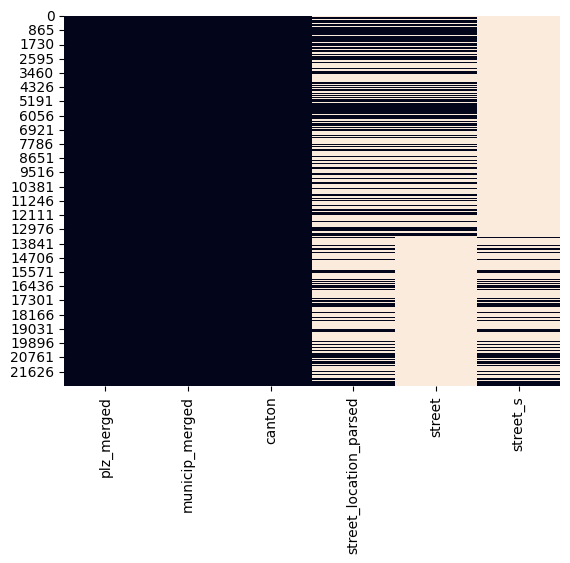

In [38]:
# Sort columns by number of non-null values
df_plz = df_plz.reindex(df_plz.count().sort_values(ascending=False).index, axis=1)

# Create isna heatmap
sns.heatmap(df_plz.isna(), cbar=False)
plt.show()


In [39]:
# Merge street and street_s
df_plz["street"] = df_plz["street"].fillna(df_plz["street_s"])


In [40]:
# Subtract the count of street_location_parsed from the count of street
df_plz["street"].count() - df_plz["street_location_parsed"].count()


48

This output shows that the column `street` contains 48 more observations than `street_location_parsed`, which is why we discard it and go with the merged `street`.

In [41]:
df_plz.drop(columns=["street_location_parsed", "street_s"], inplace=True)


In [42]:
# Cleanup street
df_plz.loc[df_plz["street"] == "-", "street"] = np.nan
df_plz.loc[df_plz["street"] == "à", "street"] = np.nan


In [43]:
# Extract street number from street
df_plz["street_nr"] = df_plz["street"].str.extract(r"^.+ (\d.+)")
df_plz["street"] = df_plz["street"].str.extract(r"^(.+?) \d")
df_plz["street"] = df_plz["street"].str.rstrip()


In [44]:
df_plz


,plz_merged,municip_merged,canton,street,street_nr
0,5023,Biberstein,AG,NaN,NaN
1,5023,Biberstein,AG,Buhldenstrasse,8d
2,5022,Rombach,AG,NaN,NaN
3,5023,Biberstein,AG,Buhaldenstrasse,8A
4,5022,Rombach,AG,NaN,NaN
...,...,...,...,...,...
22476,9470,Buchs SG,SG,Altendorferstrasse,53
22477,9500,Wil,SG,Fürstenlandstrasse,69
22478,9500,Wil SG,SG,NaN,NaN
22479,9548,Matzingen,TG,Haldenstrasse,30


# Availability

Since the availability hasn't changed, we can just process it as before.

In [45]:
availability = df["Availability_merged"].fillna(df["detail_responsive#available_from"])


In [46]:
availability.describe()


count          13355
unique           112
top       On request
freq            9631
Name: Availability_merged, dtype: object